# Gato e Cachorro com VGG16

In [1]:
# import the necessary packages
from keras.preprocessing.image import ImageDataGenerator
from keras.layers.pooling import AveragePooling2D
from keras.applications import VGG16
from keras.layers.core import Dropout
from keras.layers.core import Flatten
from keras.layers.core import Dense
from keras.layers import Input
from keras.models import Model
from keras.optimizers import Adam
from keras.utils import np_utils
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import argparse
import cv2
import os

Using TensorFlow backend.


### Importando imagens

In [2]:
dirr = '/home/matheusjerico/Documentos/DSA/05. MachineLearning/Cap-12-IntroduçãoDeepLearning/kerasDataAugmentation/dogs_vs_cats_small'

imagePaths = list(paths.list_images(dirr))
data = []
labels = []
 
# loop over the image paths
for imagePath in imagePaths:
    # extract the class label from the filename
    label = imagePath.split(os.path.sep)[-2]
 
    # load the image, swap color channels, and resize it to be a fixed
    # 128x128 pixels while ignoring aspect ratio
    image = cv2.imread(imagePath)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (128, 128))
 
    # update the data and labels lists, respectively
    data.append(image)
    labels.append(label)

### Normalizando, One Hot Encoder, Separando os dados 

In [3]:
# convert the data and labels to NumPy arrays
data = np.array(data)
labels = np.array(labels)
 
# perform one-hot encoding on the labels
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
labels = np_utils.to_categorical(labels)
 
# partition the data into training and testing splits using 75% of
# the data for training and the remaining 25% for testing
(trainX, testX, trainY, testY) = train_test_split(data, labels, test_size=0.25, stratify=labels, random_state=42)

### Image data generator

In [4]:
# initialize the training data augmentation object
trainAug = ImageDataGenerator(
    rotation_range=30,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest")
 
# initialize the validation/testing data augmentation object (which
# we'll be adding mean subtraction to)
valAug = ImageDataGenerator()
 
# define the ImageNet mean subtraction (in RGB order) and set the
# the mean subtraction value for each of the data augmentation
# objects
mean = np.array([123.68, 116.779, 103.939], dtype="float32")
trainAug.mean = mean
valAug.mean = mean

### Model VGG16

In [5]:
# load VGG16, ensuring the head FC layer sets are left off, while at
# the same time adjusting the size of the input image tensor to the
# network
# include_top = False -> tira a cabeça do modelo
baseModel = VGG16(weights="imagenet", include_top=False, input_tensor=Input(shape=(128, 128, 3)))
 
# show a summary of the base model
print("[INFO] summary for base model...")
print(baseModel.summary())

Instructions for updating:
Colocations handled automatically by placer.
[INFO] summary for base model...
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 128, 128, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 128, 128, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 128, 128, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 64, 64, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 64, 64, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 64, 64, 128)       147584    
_____________________________________

In [6]:
### Criando a saida do modelo VGG16

In [7]:
# construct the head of the model that will be placed on top of the
# the base model
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(4, 4))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(128, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(2, activation="softmax")(headModel)
 
# place the head FC model on top of the base model (this will become
# the actual model we will train)
model = Model(inputs=baseModel.input, outputs=headModel)
 
# loop over all layers in the base model and freeze them so they will
# *not* be updated during the first training process
for layer in baseModel.layers:
    layer.trainable = False

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


### Fit e Compile no modelo

In [8]:
# compile our model (this needs to be done after our setting our
# layers to being non-trainable)
print("[INFO] compiling model...")
opt = Adam(lr=1e-4)
model.compile(loss="binary_crossentropy", optimizer=opt,
    metrics=["accuracy"])
 
# train the head of the network for a few epochs (all other layers
# are frozen) -- this will allow the new FC layers to start to become
# initialized with actual "learned" values versus pure random
print("[INFO] training head...")
H = model.fit_generator(
    trainAug.flow(trainX, trainY, batch_size=32),
    steps_per_epoch=len(trainX) // 32,
    validation_data=valAug.flow(testX, testY),
    validation_steps=len(testX) // 32,
    epochs=25)

[INFO] compiling model...
[INFO] training head...
Instructions for updating:
Use tf.cast instead.
Epoch 1/25
46/46 [==============================] - 410s 9s/step - loss: 4.6867 - acc: 0.5312 - val_loss: 2.9326 - val_acc: 0.6208
Epoch 2/25
46/46 [==============================] - 417s 9s/step - loss: 3.5006 - acc: 0.6243 - val_loss: 1.7453 - val_acc: 0.7543
Epoch 3/25
46/46 [==============================] - 418s 9s/step - loss: 2.7854 - acc: 0.6752 - val_loss: 1.1749 - val_acc: 0.8077
Epoch 4/25
46/46 [==============================] - 413s 9s/step - loss: 2.3841 - acc: 0.7147 - val_loss: 0.8226 - val_acc: 0.8590
Epoch 5/25
46/46 [==============================] - 404s 9s/step - loss: 1.7698 - acc: 0.7706 - val_loss: 0.8861 - val_acc: 0.8419
Epoch 6/25
46/46 [==============================] - 401s 9s/step - loss: 1.7123 - acc: 0.7774 - val_loss: 0.7169 - val_acc: 0.8675
Epoch 7/25
46/46 [==============================] - 422s 9s/step - loss: 1.4601 - acc: 0.7903 - val_loss: 0.7135 - v

### Validação do modelo

[INFO] evaluating network...
              precision    recall  f1-score   support

        cats       0.92      0.89      0.90       250
        dogs       0.89      0.92      0.91       250

    accuracy                           0.90       500
   macro avg       0.90      0.90      0.90       500
weighted avg       0.90      0.90      0.90       500



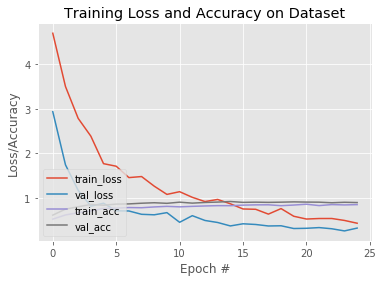

In [11]:
# evaluate the network
print("[INFO] evaluating network...")
%matplotlib inline

predictions = model.predict(testX, batch_size=32)
print(classification_report(testY.argmax(axis=1),
    predictions.argmax(axis=1), target_names=lb.classes_))
 
# plot the training loss and accuracy
N = 25
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["acc"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_acc"], label="val_acc")
plt.title("Training Loss and Accuracy on Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")